# 인물사진 만들어보기

## 루브릭
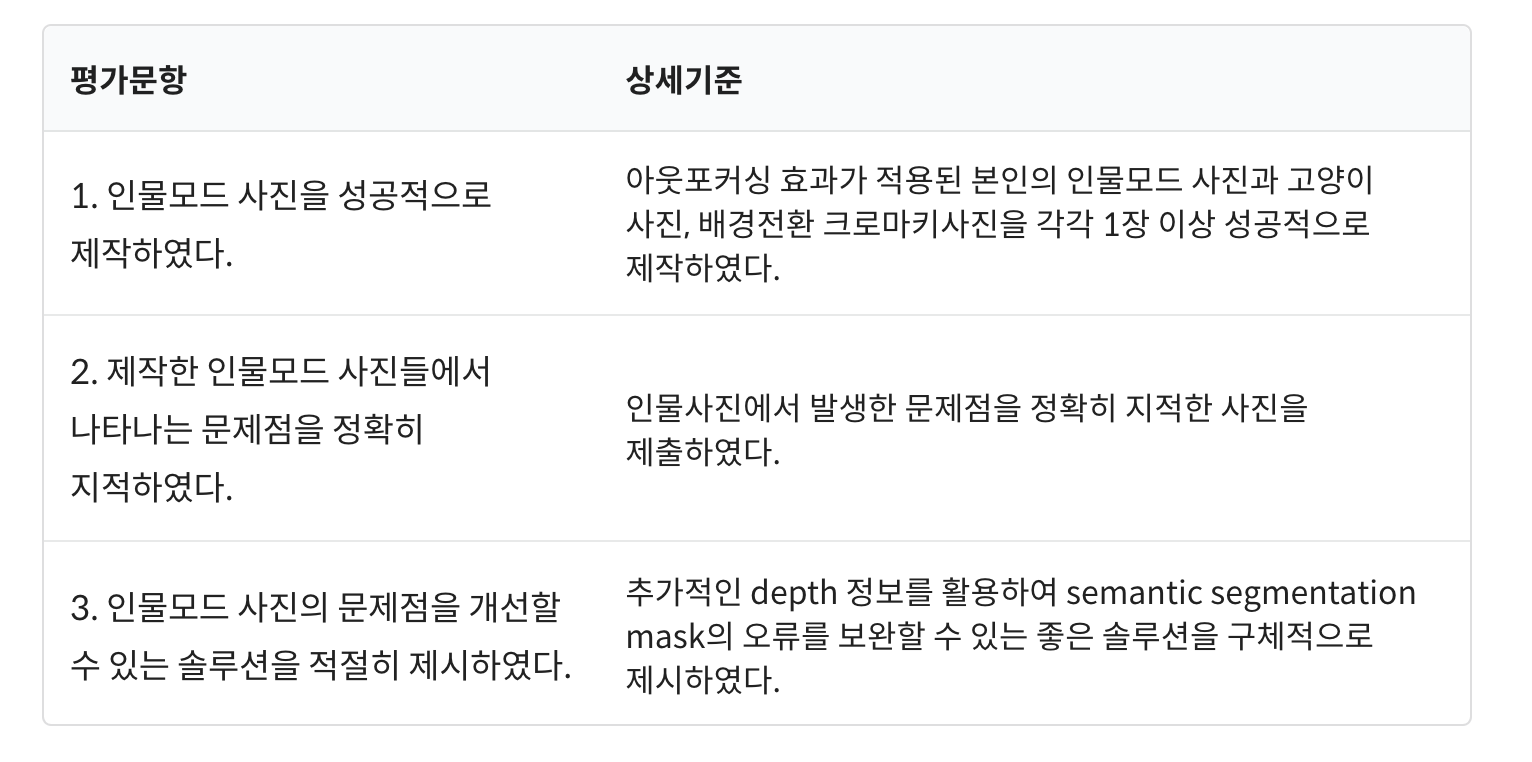



In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

## 1. 인물 포커싱

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/ssk.png'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(512, 410, 3)


In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

preprocess()는 전처리, run()은 실제로 세그멘테이션을 하는 함수이다.
모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize하고, OpenCV의 디폴트 BGR채널 순서를 텐서플로우에 맞는 RGB로 수정한다.

사전에 학습된 가중치(pretrained weight)를 불러온다.

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(512, 410, 3) (513, 410, 3) 15


In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

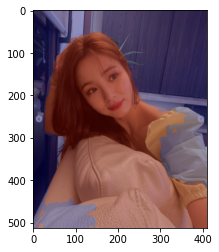

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

세그멘테이션 결과(mask)를 원래 크기로 복원하기

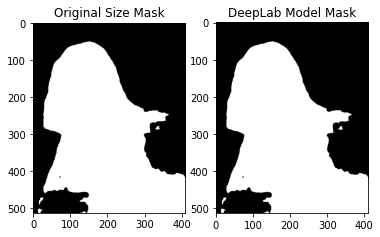

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

결과적으로 img_mask_up은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.
128을 기준으로 임계값을 만들고 그 기준으로 이하의 값은 0, 이상의 값은 255로 만든다.

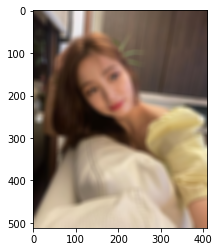

In [9]:
#블러 처리
img_orig_blur = cv2.blur(img_orig, (13,13)) #블러 커널 사이즈를 뜻함.
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

여기서 segementation mask 사용하여 배경만 추출하기

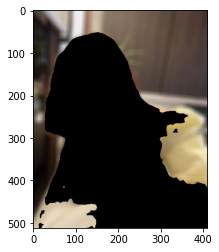

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

bitwise_not-> 이미지 반전, 배경은 255 사람은 0이 됨

이제 배경과 사람을 합치면 됨

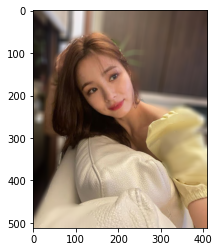

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

## 정확한 인식 실패
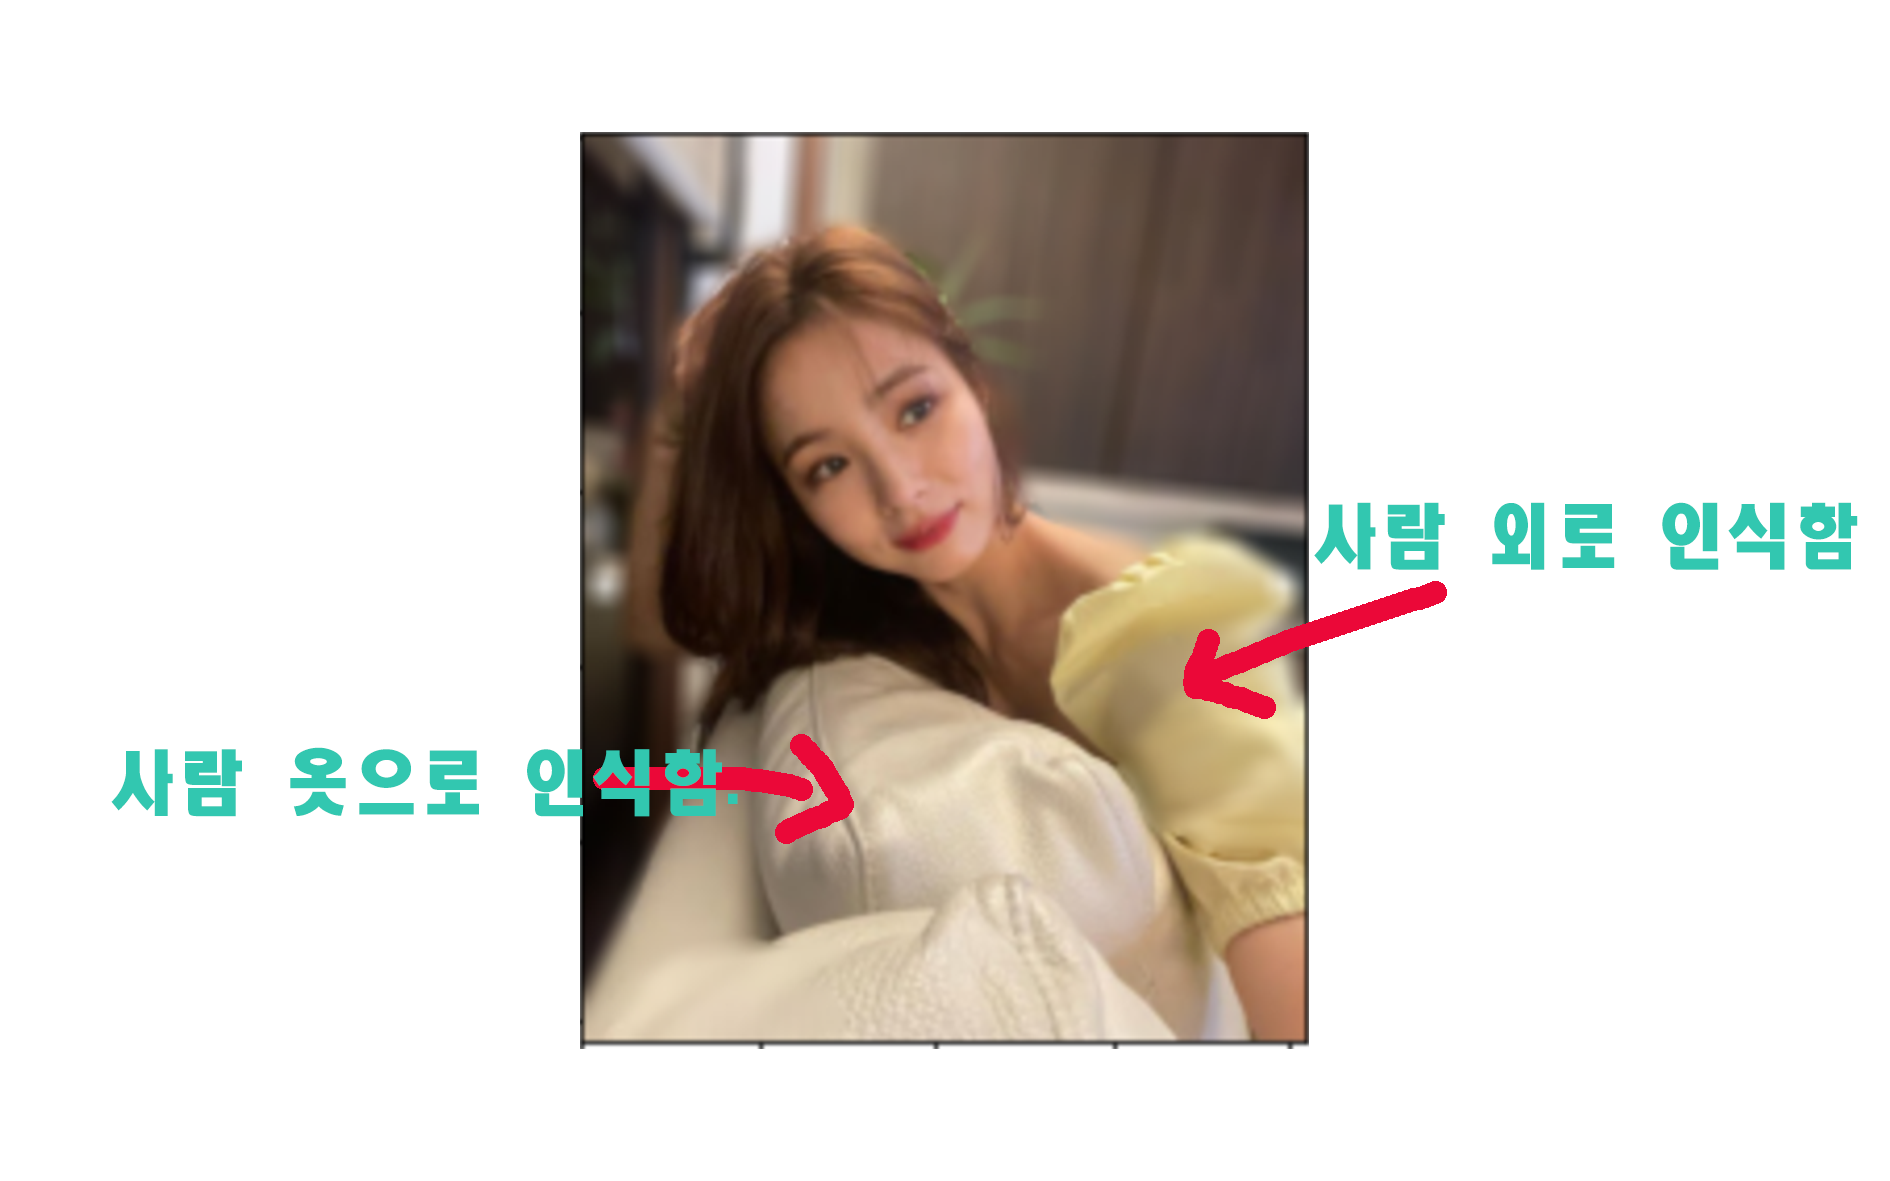

저장해볼까?


## 2. 고양이를 아웃 포커싱하기


In [12]:
#read a cat image

img_path2 = os.getenv('HOME')+'/aiffel/human_segmentation/images/bori.png'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig2 = cv2.imread(img_path2) 
print (img_orig2.shape)

(1280, 1004, 3)


In [13]:
#위에 정의한 모델 사용하여 resize와 segmentation 실행

img_resized2, seg_map2 = MODEL.run(img_orig2)# DeepLabModel 사용
print (img_orig2.shape, img_resized2.shape, seg_map2.max())

(1280, 1004, 3) (513, 402, 3) 8


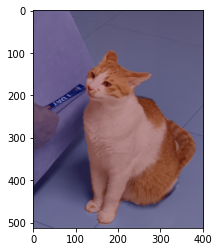

In [14]:
img_show2 = img_resized2.copy()
# seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
seg_map2 = np.where(seg_map2 == 8, 8, 0)# 고양이만 추출하기
img_mask2 = seg_map2 * (255/seg_map2.max()) # 255 normalization
img_mask2 = img_mask2.astype(np.uint8)
color_mask2 = cv2.applyColorMap(img_mask2, cv2.COLORMAP_JET)
img_show2 = cv2.addWeighted(img_show2, 0.6, color_mask2, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show2, cv2.COLOR_BGR2RGB))
plt.show()

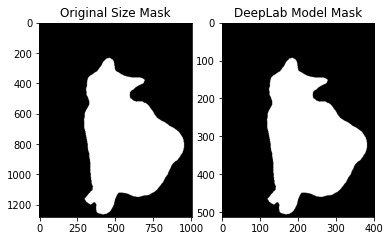

In [15]:
# 
img_mask_up2 = cv2.resize(img_mask2, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up2 = cv2.threshold(img_mask_up2, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up2, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask2, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

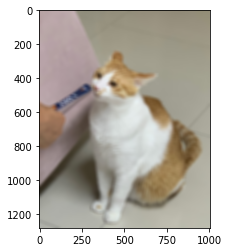

In [16]:
#블러 처리
img_orig_blur2 = cv2.blur(img_orig2, (24,24)) #좀 더 극명한 차이를 주기 위해 24으로 up
plt.imshow(cv2.cvtColor(img_orig_blur2, cv2.COLOR_BGR2RGB))
plt.show()

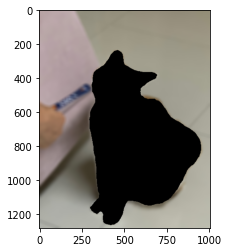

In [17]:
img_mask_color2 = cv2.cvtColor(img_mask_up2, cv2.COLOR_GRAY2BGR)
img_bg_mask2 = cv2.bitwise_not(img_mask_color2)
img_bg_blur2 = cv2.bitwise_and(img_orig_blur2, img_bg_mask2)
plt.imshow(cv2.cvtColor(img_bg_blur2, cv2.COLOR_BGR2RGB))
plt.show()

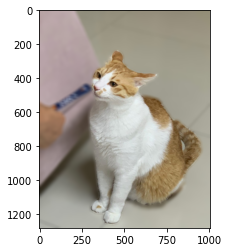

In [18]:
img_concat2 = np.where(img_mask_color2==255, img_orig2, img_bg_blur2)
plt.imshow(cv2.cvtColor(img_concat2, cv2.COLOR_BGR2RGB))

plt.show()

### 고양이 사진은 다소 단순한 요소여서 정확히 분리했다.

## 3. 크로마키 적용하기

In [251]:
#새로운 배경 이미지 불러오기
#배경으로 쓸 광화문 사진

img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/gwm.png'  
img_orig3 = cv2.imread(img_path3) 
print (img_orig3.shape)

(431, 680, 3)


In [252]:
#새로운 피사체 (cow)
img_path4 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cow.png'  
img_orig4 = cv2.imread(img_path4) 
print (img_orig4.shape)

(183, 275, 3)


In [253]:
#위에 정의한 모델 사용하여 resize와 segmentation 실행

img_resized4, seg_map4 = MODEL.run(img_orig4)# DeepLabModel 사용
print (img_orig4.shape, img_resized4.shape, seg_map4.max())

(183, 275, 3) (341, 513, 3) 10


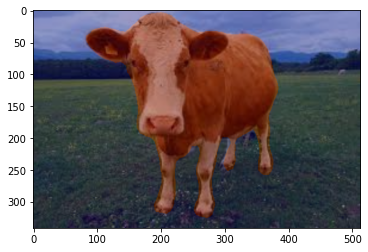

In [254]:
img_show4 = img_resized4.copy()
seg_map4 = np.where(seg_map4 == 10, 10, 0)# 소 추출
img_mask4 = seg_map4 * (255/seg_map4.max()) # 255 normalization
img_mask4 = img_mask4.astype(np.uint8)
color_mask4 = cv2.applyColorMap(img_mask4, cv2.COLORMAP_JET)
img_show4 = cv2.addWeighted(img_show4, 0.6, color_mask4, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show4, cv2.COLOR_BGR2RGB))
plt.show()

In [255]:
img_mask_up4 = cv2.resize(img_mask4, img_orig4.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up4 = cv2.threshold(img_mask_up4, 128, 255, cv2.THRESH_BINARY)

img_mask_color4 = cv2.cvtColor(img_mask_up4, cv2.COLOR_GRAY2BGR)
img_bg_mask4 = cv2.bitwise_not(img_mask_color4)


In [256]:
#광화문 사진 기준으로 shape를 통일함.
resizedCow=cv2.resize(img_orig4,(img_orig3.shape[1], img_orig3.shape[0]))
resizedGwm=cv2.resize(img_orig3,(img_orig3.shape[1], img_orig3.shape[0]))
cowMask= cv2.resize(img_mask_color4,(img_orig3.shape[1], img_orig3.shape[0]))


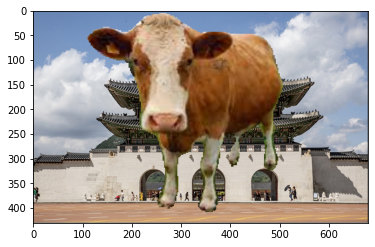

In [257]:
#광화문 이미지에 소 넣기
img_concat3 = np.where(cowMask==255, resizedCow, resizedGwm)
plt.imshow(cv2.cvtColor(img_concat3, cv2.COLOR_BGR2RGB))

plt.show()

## 회고

이미지의 shape이 같아야 합성이 된다는 사실을 알고 한 기준으로 shape를 통일하여 시도했다.  
DeepLab 모델 자체만으로는 원하는 영역의 추출이 깔끔하게 되지 않는다.  
그리고 인물 포커싱에 쓰이는 이미지가 사람의 눈으로 봐도 깔끔하게 각 요소들의 파트가 나뉘는 것이라면 semantic   
sementation mask의 효과가 좋았지만, 이미지 안에 요소들이 겹쳐있거나 어둡거나, 요소들의 파트가 정확히 나뉘지 않았다면  
해당 라벨에 포함되지 않은 요소가 포함되거나 그렇지 않게 처리됐다.  
이미지 단위가 아닌 픽셀 단위로 판별이 필요한데 서로 떨어져 있는 영역이라도 동일한 종류라고 판단 되어 클래스에 기반하여 하나의 동일한 예측 마스크값을 만든 것 같다.



## 세그맨테이션의 한계& 솔루션
- 아웃포커싱
조리개를 개방할수록 좋고(F값이 낮을수록), 셔터 스피드는 느릴수록 좋다.
그만큼 빛을 많이받아들일수록 아웃포커싱이 잘 된다는 이야기다.
카메라가 피사체를 필름에 담는 원리는 렌즈는 빛을 굴절시켜 필름에 영사시키게 하고, 렌즈를 움직여 포커싱한다.
그때 조리개는 빛을 받아들이는 양을 조절한다. 피사체에서 반사된 빛이 렌즈와 조리개를 통과하면서 필름에 맺히는데, 피사체는 필픔에 정확하게 초점이 맞춘 것이 영사되는 반면, 피사체의 뒷편에 있는 사물은 초점을 맞추지 못하고 영사된다. 그래서 뒷 배경이 날라가게 된다. 
이러한 원리를 이용하여 사진 촬영 과정에서 조리개를 조절하여 빛을 많이 받은 이미지를 만든다면, 세그맨테이션 과정에서 원할하게 영역을 나뉠 수 있게 도움이 될 것 같다.  

- Super Resolution 사용
낮은 해상도의 이미지를 고해상도로 바꾸면 경계 영역을 더 잘 구분할 것 같다.
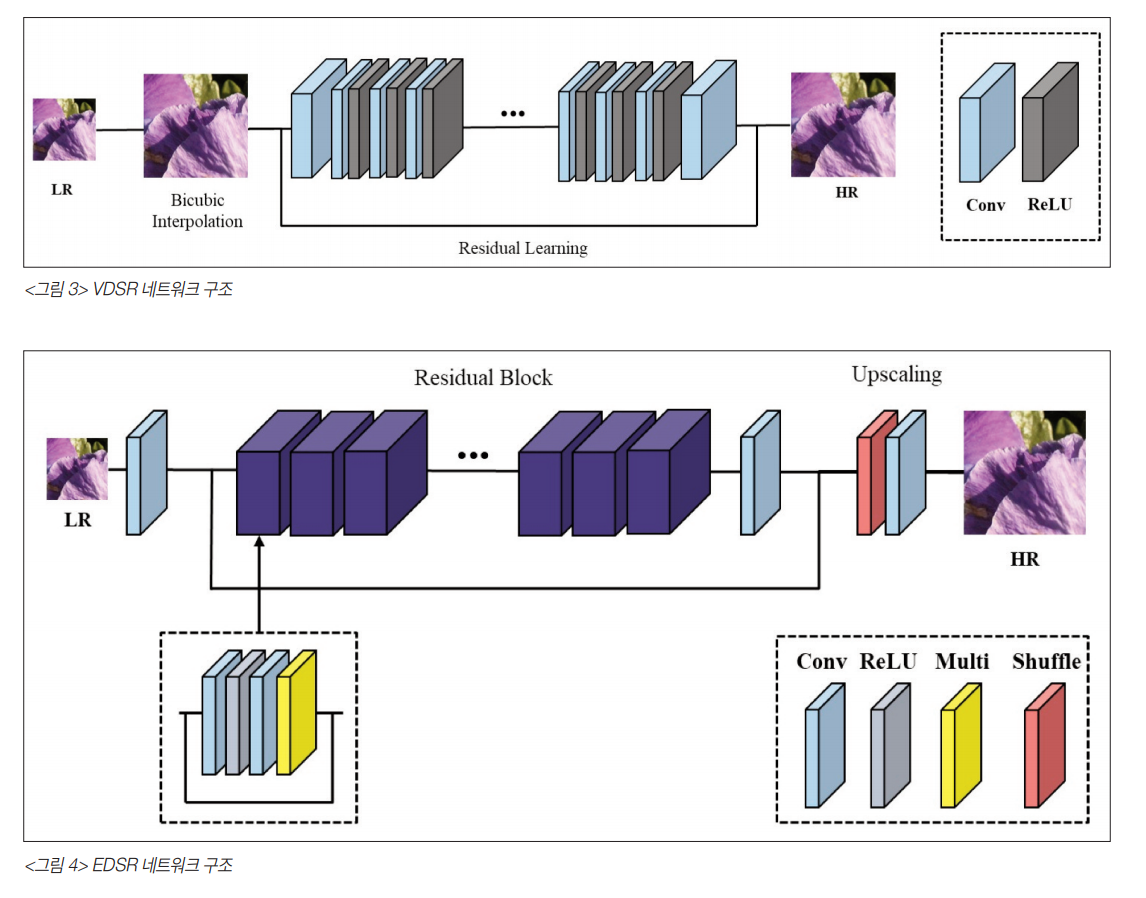


## 추가 작업
### 소가 너무 큼. 그래서 cow mask를 줄일 것이다.
### 소의 크기를 줄여 합성할 것인데, shape이 작아져 합성이 안되므로 크기를 줄인만큼 padding을 넣어 기존 shape크기에 맞출 것이다.

In [258]:
# 기존 cow Image 
resizedCow.shape


(431, 680, 3)

In [177]:
#cow를 1/10로 scailing
scale_percent =50
# width=int(resizedCow.shape[1]*scale_percent/100)
# height=int(resizedCow.shape[0]*scale_percent/100)
# dim = (width,height)
# new_resized_cow = cv2.resize(resizedCow, dim, interpolation = cv2.INTER_LINEAR) 


In [28]:
# new_resized_cow.shape

(43, 68, 3)

In [260]:
# 행 : Height, 열:width
height, width = resizedCow.shape[:2]

# 이미지 축소
reductionCow = cv2.resize(resizedCow, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
reductionCow.shape

# cowMask2 = cv2.resize(cowMask, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)
# cowMask2.shape

(216, 340, 3)

In [261]:
# 패딩을 넣어 원래 크기처럼 전체 shape을 맞춤
resized_Cow=cv2.copyMakeBorder(reductionCow,107,108,170,170,cv2.BORDER_CONSTANT)
resized_Cow.shape

(431, 680, 3)

In [262]:
img_resized5, seg_map5 = MODEL.run(resized_Cow)# DeepLabModel 사용
print (resized_Cow.shape, img_resized5.shape, seg_map5.max())

(431, 680, 3) (325, 513, 3) 10


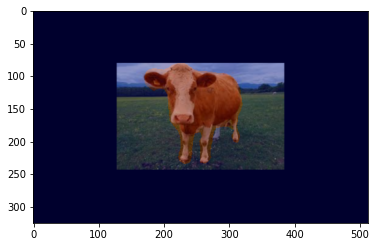

In [263]:
img_show5 = img_resized5.copy()
seg_map5 = np.where(seg_map5 == 10, 10, 0)
img_mask5 = seg_map5 * (255/seg_map5.max()) # 255 normalization
img_mask5 = img_mask5.astype(np.uint8)
color_mask5 = cv2.applyColorMap(img_mask5, cv2.COLORMAP_JET)
img_show5 = cv2.addWeighted(img_show5, 0.6, color_mask5, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show5, cv2.COLOR_BGR2RGB))
plt.show()

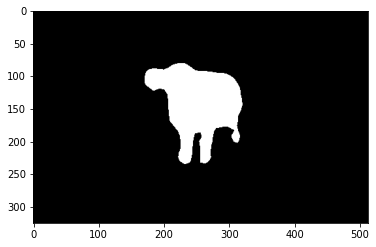

In [266]:
img_mask_up5 = cv2.resize(img_mask5, img_resized5.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up5= cv2.threshold(img_mask_up5,128, 255, cv2.THRESH_BINARY)

img_mask_color5 = cv2.cvtColor(img_mask_up5, cv2.COLOR_GRAY2BGR)
img_bg_mask5 = cv2.bitwise_not(img_mask_color5)

plt.imshow(img_mask_up5, cmap=plt.cm.binary_r)

plt.show()

In [272]:
#광화문 사진 기준으로 shape를 통일함.
resizedCow=cv2.resize(img_orig4,(img_orig3.shape[1], img_orig3.shape[0]))
resizedGwm=cv2.resize(img_orig3,(img_orig3.shape[1], img_orig3.shape[0]))
cowMask= cv2.resize(img_mask_color4,(img_orig3.shape[1], img_orig3.shape[0]))


In [293]:
# mask도 reshape 
resized_img_mask_color5==cv2.copyMakeBorder(img_orig4,124,124,202,203,cv2.BORDER_CONSTANT)
resized_img_mask_color5.shape


(431, 680, 3)